## Script to download scalar and raw data from the BPR|zero cabled at Barkley Canyon and Endeavour Main Field

In [ ]:
import requests
import pandas as pd
import logging
import os
from dotenv import load_dotenv
load_dotenv()


In [ ]:
import requests_cache

s = requests_cache.CachedSession('requests_cache')

In [ ]:
deviceCode = 'RBRQUARTZ3BPRZERO207223'


In [ ]:
ONC_TOKEN = os.getenv('ONC_TOKEN')

### Download Scalar Data using ONC Open API

In [ ]:
def get_data_from_device(device_code): # date_from, date_to, sensor_category_codes,
    url = 'https://data.oceannetworks.ca/api/scalardata'
    params = {'method': 'getByDevice',
                'token': os.getenv('ONC_TOKEN'),
                'outputFormat': 'object',
                'deviceCode': device_code,
                'dateFrom': '2021-09-10T00:00:00.000Z',
                'sensorCategoryCodes': 'pressure1',
                'resampleType': 'avg',
                'resamplePeriod': 900
                #'dateTo': '2023-11-19T00:00:00.000Z'
                #'dateTo': '2023-09-15T00:00:00.000Z'
                }

    response = requests.get(url=url, params=params)
    print(response)
    df = pd.DataFrame(response.json()['sensorData'][0]['data'])
    df.index = pd.to_datetime(df['sampleTime'])
    df['t'] = (df.index - df.index[0]).total_seconds()
    return df, response

## get the BPR|Zero data downsampled to 15min

In [ ]:
df, response = get_data_from_device(deviceCode)
df

In [ ]:
sensor_infos = []
for sensor in response.json()['sensorData']:
    sensor_info = {k: sensor.get(k, None) for k in ('sensorCategoryCode', 'sensorCode',
                                                    'sensorName', 'unitOfMeasure')}
    sensor_infos.append(sensor_info)
    
pd.DataFrame(sensor_infos)

In [ ]:
response.json()['sensorData']

In [ ]:
# filter out pressure drops due to calibration
df.loc[df['value']< 410.0,'value'] = float('nan')
df.loc[df['value']> 412.0,'value'] = float('nan')
df.head()

In [ ]:
df['value'].plot(grid=True)

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
#from scipy.stats import linregress

import matplotlib.pyplot as plt

In [ ]:
# Define the exponential decay function with a constant bias
def exponential_func_with_bias(t, A, k, b, C):
    return A * np.exp(k * t) + b*t + C

def exponential_decay_fit(df, p0=None):
    """
    Fit an exponential decay curve with a constant bias to a Pandas DataFrame with 'value' and 't' columns.

    Args:
        df (pd.DataFrame): DataFrame with 'value' and 't' columns.
        p0 (tuple, optional): Initial guess for parameters (A, k, C). If not provided, initial guesses will be determined automatically.
        
    Returns:
        tuple: A tuple containing three elements:
            1. A numpy array representing the fitted exponential decay values.
            2. A tuple of optimized parameters (A, k, C) where:
                - A: Amplitude of the decay.
                - k: Decay rate (negative).
                - C: Constant bias term.

    Raises:
        ValueError: If the DataFrame does not contain 'value' and 't' columns.

    Example:
        df = pd.DataFrame({'t': [0, 1, 2, 3, 4, 5],
                           'value': [100, 73, 54, 40, 29, 21]})
        result, params = exponential_decay_fit_with_bias_and_guess(df)
        print(params)  # (106.30146425934762, -0.3709485189378329, 15.03453660968328)
    """
    # Check if 'value' and 't' columns exist in the DataFrame
    if 'value' not in df.columns or 't' not in df.columns:
        raise ValueError("DataFrame must contain 'value' and 't' columns.")

    # Extract the data from the DataFrame
    t_data = df['t'].values
    value_data = df['value'].values

    # Fit the data to the exponential function with a constant bias
    params, covariance = curve_fit(exponential_func_with_bias, t_data, value_data, p0=p0, maxfev=10000)

    # Get the optimized parameters
    A, k, b, C = params

    # Generate the fitted curve
    fitted_values = exponential_func_with_bias(t_data, A, k, b, C)

    # Plot the original data and the fitted curve
    plt.figure(figsize=(8, 6))
    plt.scatter(t_data, value_data, label='Data', color='blue')
    plt.plot(t_data, fitted_values, label='Fitted Curve', color='red')
    plt.xlabel('Time (s)')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Exponential Decay Fit with Bias')
    plt.show()

    return fitted_values, params


def estimate_decay_rate(df):
    """
    Estimate the decay rate (k) for an exponential decay model using fitting and plot the results.

    Args:
        df (pd.DataFrame): DataFrame with 'value' and 't' columns.
        
    Returns:
        float: Estimated decay rate (k).

    Raises:
        ValueError: If the DataFrame does not contain 'value' and 't' columns.

    Example:
        df = pd.DataFrame({'t': [0, 1, 2, 3, 4, 5],
                           'value': [100, 73, 54, 40, 29, 21]})
        estimated_k = estimate_decay_rate_with_plot(df)
        print(estimated_k)  # Approximately -0.413
    """
    # Check if 'value' and 't' columns exist in the DataFrame
    if 'value' not in df.columns or 't' not in df.columns:
        raise ValueError("DataFrame must contain 'value' and 't' columns.")

    # Extract the data from the DataFrame
    t_data = df['t'].values
    value_data = df['value'].values

    # Take the natural logarithm of the values
    ln_value_data = np.log(value_data)

    # Fit an exponential decay model to the logarithmic data using polyfit
    coeffs = np.polyfit(t_data, ln_value_data, 1)

    # The coefficient is the decay rate (k)
    estimated_k = coeffs[0]

    # Calculate the fitted values
    fitted_values = np.exp(coeffs[1]) * np.exp(estimated_k * t_data)

    # Plot the original data and the fitted curve
    plt.figure(figsize=(8, 6))
    plt.scatter(t_data, value_data, label='Data', color='blue')
    plt.plot(t_data, fitted_values, label='Fitted Curve', color='red')
    plt.xlabel('Time (s)')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Exponential Decay Fit with Estimated k')
    plt.grid(True)
    plt.show()

    return estimated_k



## Find calibrations

In [ ]:
url = 'https://data.oceannetworks.ca/api/scalardata'
params = {'method': 'getByDevice',
            'token': os.environ['ONC_TOKEN'],
            'outputFormat': 'object',
            'deviceCode': deviceCode,
            #'rowLimit' : 10000,
            'sensorCategoryCodes': 'systemstatus',
            'dateFrom': '2021-09-09T00:09:30.504Z',
            'fillGaps': 'false'
            }

response = s.get(url=url, params=params)

In [ ]:
cal = pd.DataFrame(response.json()['sensorData'][0]['data'])
cal.index = pd.to_datetime(cal['sampleTime'])
cal['t'] = (cal.index - cal.index[0]).total_seconds()
cal

In [ ]:
# calibration when value == -1
cal = cal[['value','t']].diff().shift(-1)
cal = cal.loc[cal['value'] == -1]
cal

In [ ]:
def datetime2onc(dt):
    return dt.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3]+'Z'

In [ ]:
cals = {}

for ct in cal.index:
    print(ct)
    dt = pd.Timedelta('900s')
    t_start = datetime2onc(ct)
    t_end = datetime2onc(ct+dt)
    
    url = 'https://data.oceannetworks.ca/api/scalardata'
    params = {'method': 'getByDevice',
                'token': os.environ['ONC_TOKEN'],
                'outputFormat': 'object',
                'deviceCode':deviceCode ,
                'dateFrom': t_start,
                'dateTo': t_end,
                #'sensorCategoryCodes': 'pressure1,pressure4',
                #'resampleType': 'avg',
                #'resamplePeriod': 60, #900
                #'dateTo': '2023-09-15T00:00:00.000Z'
                }
    
    response = s.get(url=url, params=params)
    
    cal_dat = pd.DataFrame()
    #dfs = [pd.DataFrame(col['data']) for col in ]

    for col in response.json()['sensorData']:
        cal_dat[col['sensorName']] = pd.DataFrame(col['data'])['value']

    cal_dat['sample time'] = pd.to_datetime(pd.DataFrame(col['data'])['sampleTime'])
    cal_dat.index = (cal_dat['Instrument Clock'] - cal_dat['Instrument Clock'][0])*(24*3600) #.dt.total_seconds()
    #cal_dat = pd.DataFrame([col['value'] for col in dfs], columns=['a','b'])
    #cal_dat = pd.DataFrame(response.json()['sensorData'][0]['data'])
    #cal_dat.index = pd.to_datetime(cal_dat['sampleTime'])
    #cal_dat['t'] = (cal_dat.index - cal_dat.index[0]).total_seconds()
    
    # calibrated pressure timeseries
    cals[ct] = (cal_dat['AZA Raw Pressure']-cal_dat['AZA Reference Pressure'])

In [ ]:
a = pd.DataFrame() #index=pd.Index(range(1790))
keys = list(cals.keys())
for key in keys:
    #print(len(cals[key]))
    a[key] = cals[key].iloc[0:-1].reset_index(drop=True)

#a = cals[keys[0]]
#a.reindex_like(pd.NumericIndex(np.arange(0, 600, 0.125)))

In [ ]:
a

In [ ]:
# take care of 8 Hz sample rate
a.index = a.index/8

In [ ]:
b = a.rolling(16, center=True).mean()#.iloc[800:660*8,:]
b = b.loc[:,b.max()< 100]
b.plot(figsize=(12,12), grid=True, legend=False,
            xlabel='Time after start of calibration (s)',
            ylabel='Transfer Pressure  - Reference Pressure (dbar)')

### get BPR data from different locations

In [ ]:
def getData(locationCode, deviceCategoryCode, sensorCategoryCodes = 'pressure', dateFrom = '2009-08-01T00:00:00.000Z', session = None):

    url = 'http://data.oceannetworks.ca/api/scalardata'

    params = {
        'method': 'getByLocation',
        'token': os.environ['ONC_TOKEN'],
        'deviceCategoryCode': deviceCategoryCode,
        'locationCode': locationCode,
        'sensorCategoryCodes': sensorCategoryCodes,
        'resamplePeriod': 900,
        'resampleType': 'avgMinMax',
        'dateFrom': dateFrom,
    }
    
    dfs = []

    while 1:
        print(params['dateFrom'])
        if session:
            r = session.get(url, params=params)
        else:
            r = requests.get(url, params=params)
            
        df = pd.DataFrame(r.json()['sensorData'][0]['data'])
        df.index = pd.DatetimeIndex(df['sampleTimes'])
        dfs.append(df)
        try:
            params['dateFrom'] = r.json()['next']['parameters']['dateFrom']
        except TypeError:
            break
        
    return pd.concat(dfs)

In [ ]:
#def get_data_by_location(device_category_code='BPR', location_code = 'MEFS', sensor_category_codes='pressure1'): # date_from, date_to, sensor_category_codes,

bpr_z = getData('NCBC.P1', 'BPR', sensorCategoryCodes='pressure1', dateFrom='2021-09-10', session=s)

In [ ]:
ncbc = getData('NCBC', 'BPR', sensorCategoryCodes='pressure', dateFrom='2021-09-10', session=s)


In [ ]:
# show the calibration jumps from BPRZero ambient pressure
bpr_z['values'][0:200].plot()

In [ ]:
# clean BPRZero pressure sensor values of calibration jumps

bpr_z['cleaned'] = bpr_z['values'].copy()
bpr_z.loc[bpr_z['cleaned']< 409,'cleaned'] = float('nan')

In [ ]:
# NCBC comparison
# get NCBC for BPRZero dates and subtract BPRzero pressure
ec_diff = (ncbc['values'].reindex_like(bpr_z['cleaned'])-bpr_z['cleaned'])

ec_diff = ec_diff - ec_diff.iloc[0]
ec_diff[ec_diff > 0.2] = float('nan')
ec_diff[ec_diff < -0.002] = float('nan')

ax = ec_diff.plot(grid=True, figsize=(12,8), label='NCBC -  BPR-Z')
ec_diff.rolling('25h', center=True).mean().plot(ax=ax,grid=True, figsize=(12,8),label='25h rolling mean')

# adjust the calibrations to fit the drift curve at the beginning (exponential part)
#(-1*(cal - cal.iloc[0]) - 0.02).plot(ax = ax, figsize=(12,8), grid=True, marker='.', label='Calibration')

ax.set_xlabel('Time')
ax.set_ylabel('Pressure difference (dbar | m)')
ax.legend()
ax.set_title('NCBC vs BPR Zero')

In [ ]:
# NCBC zoom
# get NCBC for BPRZero dates and subtract BPRzero pressure
ec_diff = (ncbc['values'].reindex_like(bpr_z['cleaned'])-bpr_z['cleaned'])

ec_diff = ec_diff - ec_diff.iloc[0]
ec_diff[ec_diff > 0.2] = float('nan')
ec_diff[ec_diff < -0.002] = float('nan')
ax = ec_diff.plot(grid=True, figsize=(12,8), label='NCBC vs BPR-Z')
ec_diff.rolling('25h', center=True).mean().plot(ax=ax,grid=True, figsize=(12,8),label='25h rolling mean')

#(-1*(cal - cal.iloc[0]) - 0.02).plot(ax = ax, figsize=(12,8), grid=True, marker='.',markersize=12.5, label='Calibration')

ax.set_xlabel('Time')
ax.set_xlim(['2021-09-01 00:00','2022-03-01 00:00'])
ax.set_ylabel('Pressure difference (dbar | m)')
ax.legend()
ax.set_title('NCBC vs BPR Zero')

## get archived raw data via ONC Open API client library

In [63]:
from dotenv import load_dotenv
load_dotenv()
import os
from onc import ONC
onc = ONC(token=os.getenv('ONC_TOKEN'))

In [ ]:
# advantage of onc API client versus request method is paging: As the OpenAPI only allows 100,000 lines per output, you'd need to enter
# new dateFrom dateTo every time you reached the limit. The client library does that for you using the parameter allPages! 
params = {
                'deviceCode': deviceCode,
                'dateFrom': '2022-04-05T00:00:00.000Z',
                'dateTo': '2022-04-06T00:00:00.000Z'
                #'dateTo': '2023-09-15T00:00:00.000Z'
                }
                
data = onc.getDirectRawByDevice(params, allPages=True)

Data quantity is greater than the row limit and will be downloaded in multiple pages.
Estimated approx. 7 pages in total.
Estimated approx. 28 seconds to complete for the rest of the pages.

   (100000 samples) Downloading page 2...
   (200000 samples) Downloading page 3...
   (300000 samples) Downloading page 4...
   (400000 samples) Downloading page 5...
   (500000 samples) Downloading page 6...
   (600000 samples) Downloading page 7...
   (690611 samples) Completed in 39 seconds.


In [65]:
data.keys()

dict_keys(['citations', 'data', 'messages', 'next', 'outputFormat', 'queryUrl'])

In [74]:
df = pd.DataFrame(data['data'])
df.head()

,lineTypes,readings,times
0,,"2022-04-04 23:59:48.500, 5.703713321518759e+00...",2022-04-05T00:00:00.030Z
1,,"2022-04-04 23:59:48.625, 5.703722415410835e+00...",2022-04-05T00:00:00.156Z
2,,"2022-04-04 23:59:48.750, 5.703704227626568e+00...",2022-04-05T00:00:00.281Z
3,,"2022-04-04 23:59:48.875, 5.703695133734265e+00...",2022-04-05T00:00:00.406Z
4,,"2022-04-04 23:59:49.000, 5.703722415410835e+00...",2022-04-05T00:00:00.531Z


In [ ]:
# find messages in the raw data readings
df.loc[(df['readings'].str.contains('deployment status', na=False))]

,lineTypes,readings,times
483020,>,deployment status,2022-04-05T16:47:21.219Z
483021,<,deployment status = full,2022-04-05T16:47:21.220Z


### Now I only want to keep readings that have data, no commands or returns from the driver

In [ ]:
import numpy as np
# 1. Find the physical integer positions of all rows containing only data (no driver commands)
match_positions = np.where(df['lineTypes'].str.contains('', na=False))[0]
df2 = df.iloc[match_positions]

In [101]:
df2.head()

,lineTypes,readings,times
0,,"2022-04-04 23:59:48.500, 5.703713321518759e+00...",2022-04-05T00:00:00.030Z
1,,"2022-04-04 23:59:48.625, 5.703722415410835e+00...",2022-04-05T00:00:00.156Z
2,,"2022-04-04 23:59:48.750, 5.703704227626568e+00...",2022-04-05T00:00:00.281Z
3,,"2022-04-04 23:59:48.875, 5.703695133734265e+00...",2022-04-05T00:00:00.406Z
4,,"2022-04-04 23:59:49.000, 5.703722415410835e+00...",2022-04-05T00:00:00.531Z


In [83]:
df2.set_index(pd.to_datetime(df2['times']),inplace=True)

In [ ]:
# split column readings for individual sensors
df_split = df2['readings'].str.split(',', expand=True)
df_split.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,2022-04-04 23:59:48.500,5.703713321518759e+000,411.0109894617013e+000,5.41613700e+000,6.689310685059169e+000,9.622556718585654e+000,30.09943545795977e+006,5.816777441650629e+006,29.74867368116975e+006,5.805245577357709e+006,None,None,None,None,None,None,None,None
1,2022-04-04 23:59:48.625,5.703722415410835e+000,411.0094951101225e+000,5.41601500e+000,6.689319758431625e+000,9.622556383202422e+000,30.09943536482751e+006,5.816777439322323e+006,29.74867512471974e+006,5.805245575029403e+006,None,None,None,None,None,None,None,None
2,2022-04-04 23:59:48.750,5.703704227626568e+000,411.0101018137031e+000,5.41586300e+000,6.689310685059169e+000,9.622555970490232e+000,30.09943525306880e+006,5.816777441650629e+006,29.74867453798652e+006,5.805245579686016e+006,None,None,None,None,None,None,None,None
3,2022-04-04 23:59:48.875,5.703695133734265e+000,411.0058099325651e+000,5.41598500e+000,6.689319758431625e+000,9.622556111167728e+000,30.09943529032171e+006,5.816777439322323e+006,29.74867868237197e+006,5.805245582014322e+006,None,None,None,None,None,None,None,None
4,2022-04-04 23:59:49.000,5.703722415410835e+000,411.0045768130752e+000,5.41574100e+000,6.689310685059169e+000,9.622555358412160e+000,30.09943508543074e+006,5.816777441650629e+006,29.74867987446487e+006,5.805245575029403e+006,None,None,None,None,None,None,None,None


In [ ]:
# convert strings to numneric values
df_split['SF pressure'] = pd.to_numeric(df_split[1], errors='coerce')
df_split['SF Temperature'] = pd.to_numeric(df_split[2], errors='coerce')
df_split['Baro pressure'] = pd.to_numeric(df_split[4], errors='coerce')
df_split['Baro Temperature'] = pd.to_numeric(df_split[5], errors='coerce')


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

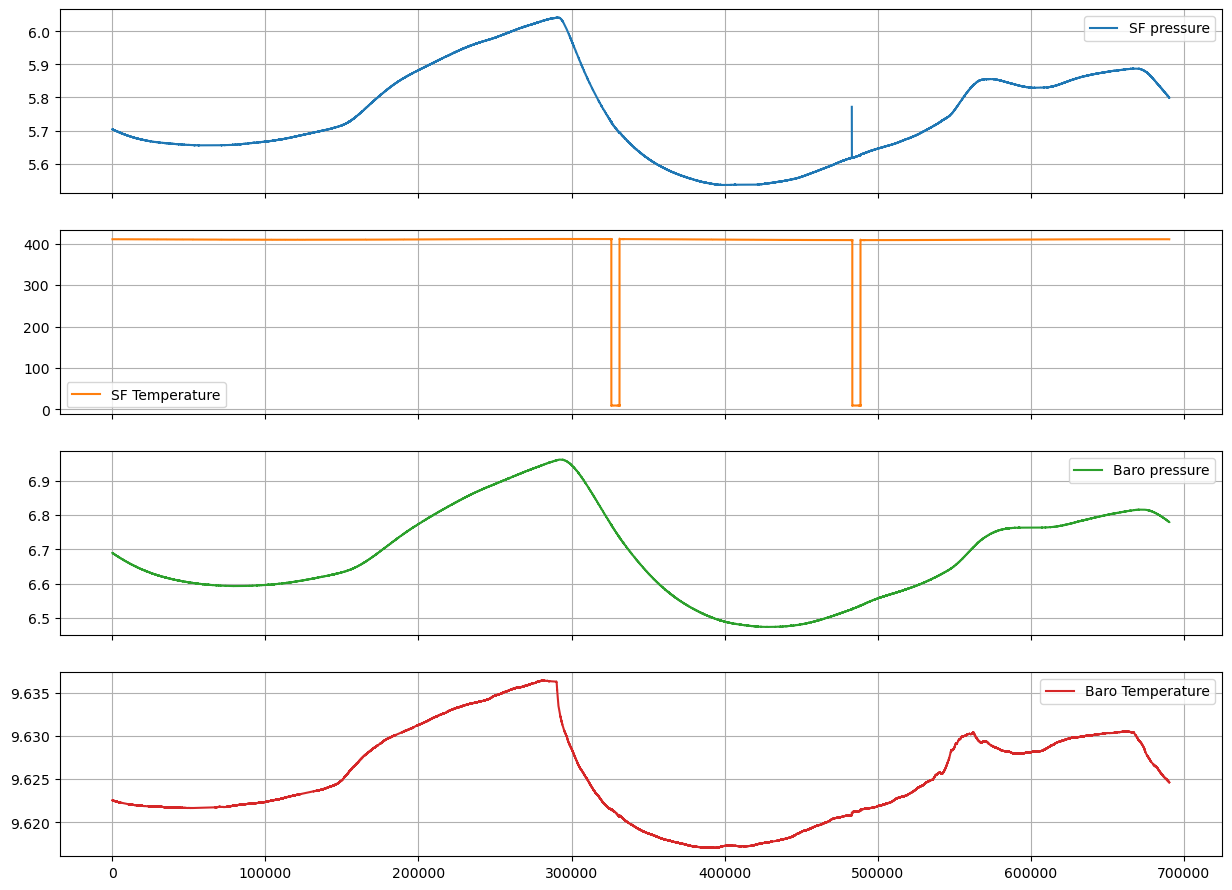

In [106]:
df_split[['SF pressure','SF Temperature','Baro pressure', 'Baro Temperature']].plot(subplots=True,sharex=True, grid=True,figsize=[15,11])